Для выполнения работы используется тот же набор данных Automobile Dataset, применявшийся в предыдущих заданиях. 

В рамках работы требуется решить задачу классификации, то есть предсказать категориальный (классовый) признак на основе числовых характеристик. 
В исходном датасете присутствует атрибут origin, отражающий страну происхождения автомобилей (USA, Europe, Japan). Однако классы по этому признаку выражены неравномерно - автомобилей из США значительно больше, чем из Европы и Японии. Такой дисбаланс приводит к смещению обучения моделей и снижению объективности метрик.

Поэтому введен новый бинарный признак economy_class, отражающий топливную эффективность автомобиля:
1 - автомобиль экономичный (расход топлива выше медианного значения по mpg).
0 - автомобиль менее экономичный (расход ниже медианы).

Подгрузим датасет и проведем техническую подготовку для корректной работы алгоритмов классификации, заменив пропуски в horsepower на среднее значение и удалив оставшиеся неполные строки (если есть).

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

df = pd.read_csv("Automobile.csv")

# Обработка пропусков и удаление неполных строк
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())
df = df.dropna().reset_index(drop=True)

print("Размерность набора данных:", df.shape)
print("Количество пропусков после очистки:")
print(df.isna().sum())

Размерность набора данных: (398, 9)
Количество пропусков после очистки:
name            0
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64


Создадим бинарный целевой признак economy_class на основе медианного значения mpg.

In [3]:
mpg_median = df['mpg'].median()

# Бинарный класс: 1 - экономичные, 0 - неэкономичные
df['economy_class'] = (df['mpg'] > mpg_median).astype(int)

print(df['economy_class'].value_counts())
print((df['economy_class'].value_counts(normalize=True) * 100).round(2))

economy_class
0    207
1    191
Name: count, dtype: int64
economy_class
0    52.01
1    47.99
Name: proportion, dtype: float64


k-Nearest Neighbors (kNN) - метод ближайших соседей, основывающийся на расстояниях между объектами.
Decision Tree (дерево решений) - интерпретируемая модель, разделяющая данные по признакам, максимизируя чистоту классов на каждом шаге.

В качестве признаков используем следующие числовые атрибуты: horsepower, weight, acceleration, displacement, cylinders, power_to_weight.
Добавим признак power_to_weight - удельную мощность автомобиля, так как он отражает соотнешие мощности и массы и напрямую связан с экономичностью.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

df['power_to_weight'] = df['horsepower'] / df['weight']

features = ['horsepower', 'weight', 'acceleration', 'displacement', 'cylinders', 'power_to_weight']
target = 'economy_class'

X = df[features]
y = df[target]

# Масштабирование числовых признаков (устойчиво к выбросам)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (318, 6)
Размер тестовой выборки: (80, 6)


kNN классифицирует объект по большинству классов среди его ближайших соседей. Для подбора оптимального числа соседей k выполним тестирование на диапазоне от 3 до 15. После подбора параметра k выберем оптимальное значение по максимальному F1-score и ROC-AUC.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import numpy as np

results_knn = []

for k in range(3, 16):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train, y_train)
    y_pred = model_knn.predict(X_test)
    y_proba = model_knn.predict_proba(X_test)[:, 1]
    
    results_knn.append({
        'k': k,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

results_knn = pd.DataFrame(results_knn)
display(results_knn)

best_k = results_knn.loc[results_knn['roc_auc'].idxmax(), 'k']
print("Оптимальное значение k:", best_k)

,k,accuracy,precision,recall,f1,roc_auc
0,3,0.9000,0.875000,0.921053,0.897436,0.972431
1,4,0.8625,0.864865,0.842105,0.853333,0.963033
2,5,0.8750,0.818182,0.947368,0.878049,0.962719
3,6,0.9000,0.857143,0.947368,0.900000,0.968045
4,7,0.9000,0.840909,0.973684,0.902439,0.961779
5,8,0.8750,0.833333,0.921053,0.875000,0.960526
6,9,0.8625,0.813953,0.921053,0.864198,0.956767
7,10,0.8625,0.813953,0.921053,0.864198,0.954261
8,11,0.8750,0.818182,0.947368,0.878049,0.959273
9,12,0.8625,0.813953,0.921053,0.864198,0.966165


Оптимальное значение k: 3


Модель дерева решений формирует иерархию правил, делящих данные на подгруппы. Подберем параметры max_depth (глубина дерева) и min_samples_leaf(минимум объектов в листе), чтобы избежать переобучения и достичь сбалансированного результата. После подбора выберем дерево с максимальным ROC-AUC.

In [8]:
from sklearn.tree import DecisionTreeClassifier

results_tree = []

for depth in [3, 5, 7, 9, None]:
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_tree.fit(X_train, y_train)
    y_pred = model_tree.predict(X_test)
    y_proba = model_tree.predict_proba(X_test)[:, 1]
    
    results_tree.append({
        'max_depth': depth,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

results_tree = pd.DataFrame(results_tree)
display(results_tree)

best_depth = results_tree.loc[results_tree['roc_auc'].idxmax(), 'max_depth']
print("Оптимальная глубина дерева:", best_depth)

,max_depth,accuracy,precision,recall,f1,roc_auc
0,3.0,0.9000,0.857143,0.947368,0.900000,0.938596
1,5.0,0.8625,0.885714,0.815789,0.849315,0.962406
2,7.0,0.8625,0.864865,0.842105,0.853333,0.883145
3,9.0,0.8500,0.842105,0.842105,0.842105,0.864035
4,NaN,0.8750,0.850000,0.894737,0.871795,0.875940


Оптимальная глубина дерева: 5.0


После подбора оптимального k = 3 для kNN и max_depth = 5 для дерева решений проведем финальное сравнение их работы на тестовой выборке.
В качестве метрик оценки качества используются:
Accuracy - доля верно классифицированных примеров.
Precision - точность по положительному классу. 
Recall - полнота (доля правильно найденных положительных объектов).
F1-мера - гармоническое среднее между Precision и Recall.
ROC-AUC - качество ранжирования предсказаний (чем ближе к 1, тем лучше).

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

# Финальное обучение лучших моделей
knn_best = KNeighborsClassifier(n_neighbors=3)
tree_best = DecisionTreeClassifier(max_depth=5, random_state=42)

knn_best.fit(X_train, y_train)
tree_best.fit(X_train, y_train)

# Предсказания и вероятности
y_pred_knn = knn_best.predict(X_test)
y_pred_tree = tree_best.predict(X_test)

y_proba_knn = knn_best.predict_proba(X_test)[:, 1]
y_proba_tree = tree_best.predict_proba(X_test)[:, 1]

# Сводные метрики
results_final = pd.DataFrame([
    {
        'Модель': 'kNN',
        'Accuracy': accuracy_score(y_test, y_pred_knn),
        'Precision': precision_score(y_test, y_pred_knn),
        'Recall': recall_score(y_test, y_pred_knn),
        'F1': f1_score(y_test, y_pred_knn),
        'ROC-AUC': roc_auc_score(y_test, y_proba_knn)
    },
    {
        'Модель': 'Decision Tree',
        'Accuracy': accuracy_score(y_test, y_pred_tree),
        'Precision': precision_score(y_test, y_pred_tree),
        'Recall': recall_score(y_test, y_pred_tree),
        'F1': f1_score(y_test, y_pred_tree),
        'ROC-AUC': roc_auc_score(y_test, y_proba_tree)
    }
])

display(results_final)

,Модель,Accuracy,Precision,Recall,F1,ROC-AUC
0,kNN,0.9000,0.875000,0.921053,0.897436,0.972431
1,Decision Tree,0.8625,0.885714,0.815789,0.849315,0.962406


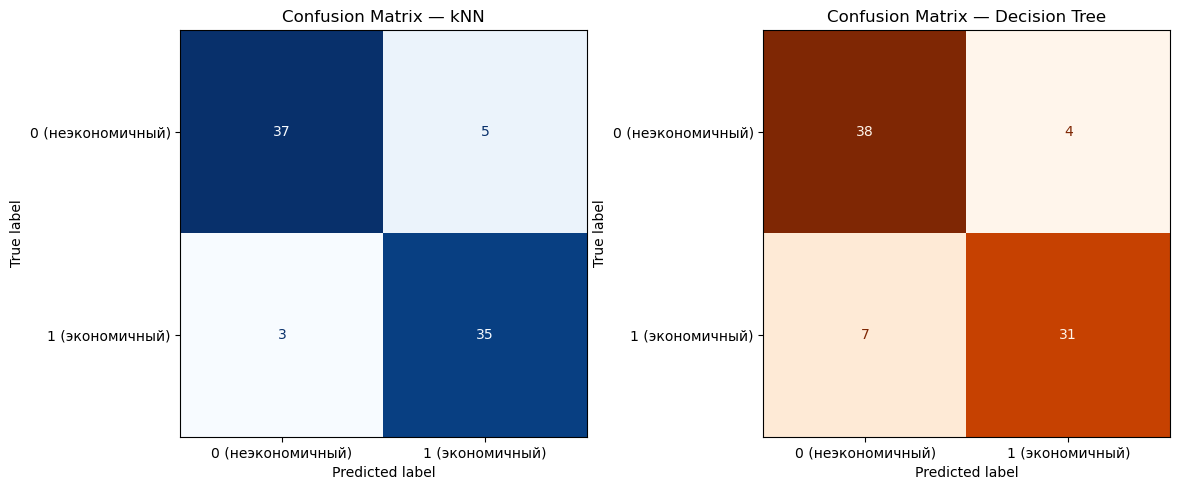

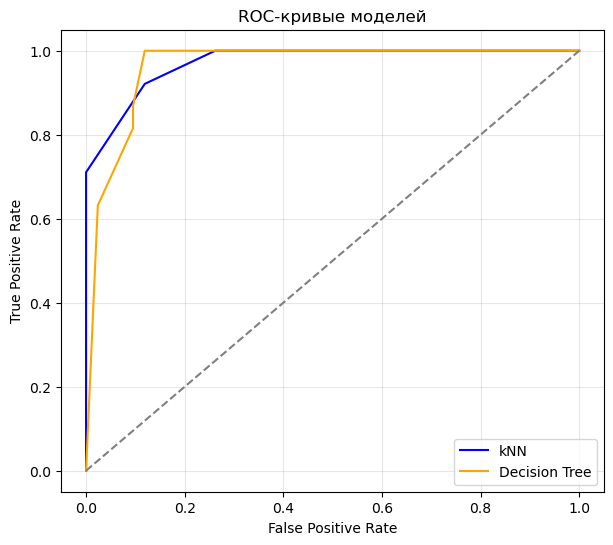

In [11]:
import matplotlib.pyplot as plt
# Матрицы ошибок
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=["0 (неэкономичный)", "1 (экономичный)"]).plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Confusion Matrix — kNN")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tree), display_labels=["0 (неэкономичный)", "1 (экономичный)"]).plot(ax=ax[1], cmap="Oranges", colorbar=False)
ax[1].set_title("Confusion Matrix — Decision Tree")
plt.tight_layout()
plt.show()

# ROC-кривые
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)

plt.figure(figsize=(7, 6))
plt.plot(fpr_knn, tpr_knn, label="kNN", color="blue")
plt.plot(fpr_tree, tpr_tree, label="Decision Tree", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые моделей")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Визуальный анализ показывает (матрицы ошибок и roc-кривые) показал высокое качество обеих моделей. 
kNN - обеспечивает наилучшие результаты по показателям Recall, F1 и ROC-AUC, что говорит о его способости точнее классифицировать экономичные авто.
Decision tree - демонстрирует сопоставимую точность, но проявляет большую осторожность при отнесении объектов к классу "экономичный" - из-за чего имеет чуть меньший Recall, но более высокую Precision. 

Высокие показатели ROC-AUC (0.96-0.97) показывают, что обе модели хорошо отделяют экономичные автомобили от неэкономичных. Это происходит потому, что исходные признаки (мощность, вес и т.д.) логически и статистически связаны с топливной эффективностью - модель легко улавливает эти зависимости.

Различие в поведении моделей объясняется их природой: 
kNN учитывает локальное окружение объектов, поэтому лучше подстраивается под плавные переходы между классами.
Decision Tree опирается на пороговые разбиения и строит более жесткие границы, что делает его чуть менее гибким, но более интерпретируемым.

Вывод:
Результаты моделей: kNN: Accuracy 0.9000, Precision 0.875000, Recall 0.921053, F1 0.897436, ROC‑AUC 0.972431.
Decision Tree (best): Accuracy 0.8625, Precision 0.885714, Recall 0.815789, F1 0.849315, ROC‑AUC 0.962406.

Обе модели показали высокую эффективность классификации на сбалансированном наборе данных. Метод kNN оказался немного более точным и чувствительным к экономичным авто, в то время как Decision Tree проявил большую устойчивость и осторожность в прогнозах.

В целом обе модели успешно решают поставленную задачу - предсказание топливной эффективности автомобилей по их техническим характеристикам, демонстрируя качество на уровне ROC-AUC, близком к 1, что соответствует отличной способности различать классы.